### Customer value estimation


#### Product margin

Unfortunately, margin on user-item transaction are omitted in the available datasets. To include the profit aspect of the customer relationship management, we propose simulation approach describing changes in product margin over time, which are consequently used for estimating customer profit. That is, for each of the product, we draw from initial random normal distribution. This draw serves as a starting point for the random walk, which we simulate using draws from random normal distribution for step difference and put them together using cumulative sum. In other words, we use one dimensional random walk with random normal steps. For product *p* in time *t*, we estimate the margin *m* like this:
   
$$m^{p}_t = Normal(\mu_0, \sigma_0)+\sum^{t}_{n=1}{Normal(\mu_{diff}, \sigma_{diff})}$$

where the first element represents the starting draw, and the second element represents the cumulative sum of difference draws. For simplicity, we assume that initial variability across products and variability of the product, within the observed period, are the same. Thus, we set $\mu_{diff} = 0$, and $\sigma_{diff}=\frac{\sigma_0}{\sqrt{t}}$.  As a result, we are able to estimate product profit with respect to just parameters of the initial random draw $\mu_{0}$ and $\sigma_{0}$.

#### Customer value

The customer value is computed as cumulative average profit using product revenue and simulated margin, result is scaled to reflect the target window size. This approach allows us to differentiate customer profit on individual level, indicate changes in customer behavior over time, and is useful in time-framed campaigns.
Cumulative average scales down value of customers with prolonged periods without a transaction, this aspect may be taken further using windowing or explicit decay function.
On the other hand, it is fairly limited by the window size and does not reflect on lifecycle length such as $CLV$. Let as have a customer $i$ at time $t$, the customer value can be computed as $$ CV^{i}_t = \frac{n_t}{t}\sum^{t}_{n=1}{m^{p}_n  r^{p}_n} $$

where $n_t$ represent the length of the target window, $m^{p}_n$ stands for simulated margin for product $p$ in the time $n$, and $r^{p}_n$ is the revenue from transaction realized on product $p$ in the time $n$.
Overall customer profit can be simply reconstructed with knowledge of the relationship length, same is true for CLV.
 

In [1]:
from itertools import product
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt    
from multiprocessing import Pool  

In [2]:
def simulate_margin(products, dates, loc, scale):
    n_products = len(products)
    n_days = len(dates)    

    scale_diff = scale/np.sqrt(n_days)
    product_baseline = np.random.normal(loc=loc,scale=scale,size=(n_products,1))
    product_diff = np.random.normal(loc=0, scale=scale_diff, size=(n_products, n_days-1))
    margins = np.cumsum(np.concatenate([product_baseline, product_diff], axis=1), axis=1)
    margins = pd.DataFrame(margins, columns=dates)
    margins["product_id"] = products
    return margins

def plot_simulated_data(data, setup):
    x, y, hue = setup["x"], setup["y"], setup["hue"]
    labs = setup["labs"]
    fig, axs = plt.subplots(1,2, figsize=(20,7.5))
    # walk
    sns.lineplot(data=data,
        x=x, y=y, hue=hue,
        legend=False, palette=sns.color_palette("rocket_r", as_cmap=True),
        alpha=0.5, ax=axs[0]);
    axs[0].set_ylabel(labs["y"]);
    axs[0].tick_params(axis='x', rotation=90);
    axs[0].set_xlabel(labs["x"]);
    # hist
    sns.histplot(data=data,
        x=y, bins=50,
        color=sns.color_palette("rocket",10)[1],
        ax=axs[1]);
    axs[1].set_ylabel("frequency");
    axs[1].set_xlabel(labs["y"]);

def get_purchases(path="../data/raw/retailrocket/events"):
    events = pd.read_parquet(path).drop_duplicates()
    purchases = events[events.event_type_name=="purchase"]
    purchases.loc[:,"date"] = purchases.event_time.dt.date
    purchases["week_start"] = purchases["date"] -\
        pd.to_timedelta(purchases["event_time"].dt.dayofweek, unit="d")
    return purchases    

def get_cust_value(purchases, margins, target_size=4):
    purchases = purchases.merge(margins, on=["product_id","date"], how="inner")
    purchases["profit"] = purchases.revenue*purchases.margin
    purchases = purchases.groupby(["user_id", "week_start"], as_index=False)\
        .agg(profit=("profit", sum), revenue=("revenue", sum))
    user_week_product = product(purchases.user_id.unique(), purchases.week_start.unique())
    user_cap = pd.DataFrame(user_week_product, columns=["user_id", "week_start"])\
        .merge(purchases, on=["user_id", "week_start"], how="left")\
            .fillna(0).sort_values("week_start")\
                .rename(columns={"week_start":"date"})
    user_cap["cv"] = target_size*user_cap.groupby("user_id").profit.cumsum()/\
        (user_cap.groupby("user_id").cumcount()+1)
    return user_cap.loc[:,["user_id", "date", "cv"]]

#### Simulated product margins

In the plots below, we show simulated margins for the `retailrocket` datasets. On the left, we see margin changes over time - the random walk. On the right we see overall margin distribution. Both plots are in line with the parameters of the simulation and reflects common e-commerce retail business - most of the products show positive margin, however there are a few products generating loss.

/tmp/ipykernel_750/4184237393.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases.loc[:,"date"] = purchases.event_time.dt.date
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  warnings.warn(
/tmp/ipykernel_750/4184237393.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases["week_start"] = purchases["date"] -\


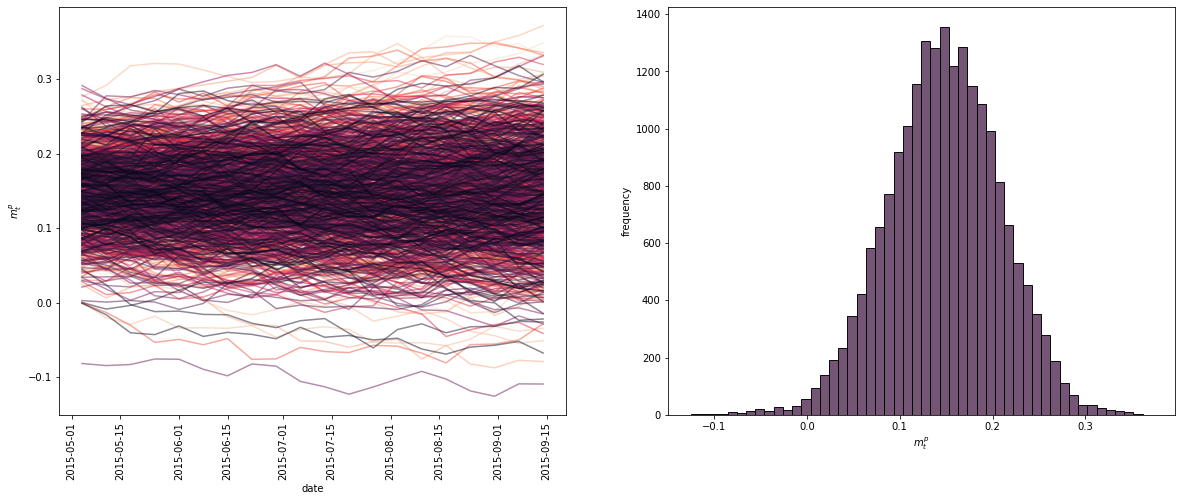

In [3]:
# SIMULATE MARGINS
purchases = get_purchases()
# simulation
loc = 0.15
scale = 0.05
dates = purchases.sort_values("week_start").week_start.unique()
products = purchases.product_id.unique()
margins = simulate_margin(products, dates, loc, scale)
margins = pd.melt(margins, id_vars=["product_id"],
        var_name="date", value_name="margin")
# plot
prod_subset = margins.product_id.isin(margins.product_id.unique()[:1000])
plot_conf = {"x":"date", "y":"margin", "hue":"product_id", "labs":{"x":"date", "y":"$m^p_t$"}}    
plot_simulated_data(margins[prod_subset], plot_conf)

### Estimated CV

Now, with estimated margins one can take a look at development of customer's cumulative average profit and its overall distribution. On the left, we see changes in $CV$ over time. The most dominant pattern consists of a peak (one or more transactions) and decay (no further transactions). Only a few customers do repeated purchases, which once again stress the importance of customer retention.
On the right we see overal $CV$ distribution, centered around zero with right-tail. The shape is result of the said dominant pattern.

DescribeResult(nobs=3401, minmax=(-621.466775264316, 620493.0381522679), mean=20889.976291301267, variance=2487884007.6016994, skewness=4.19146958210018, kurtosis=23.134788251776108)

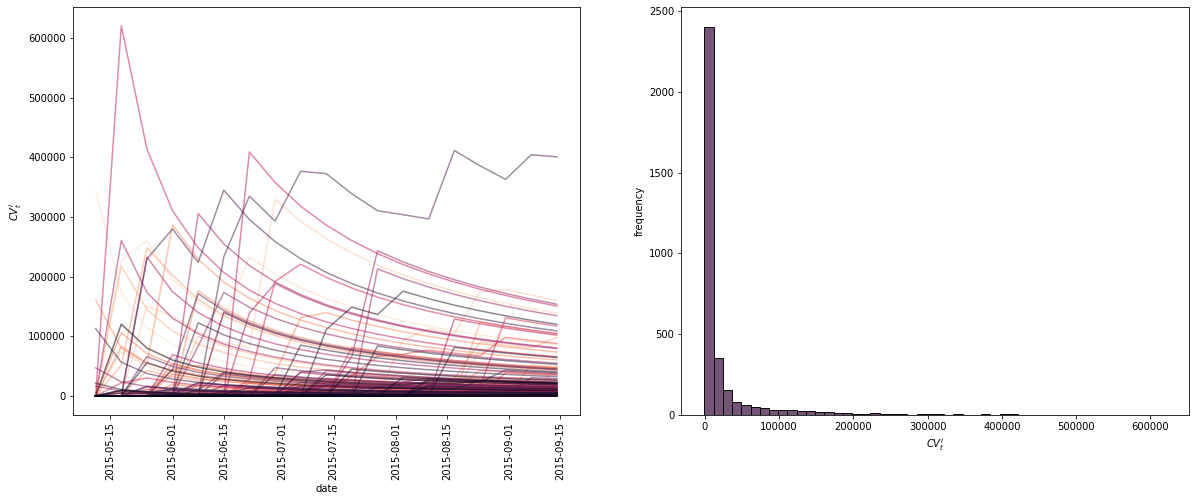

In [4]:
cust_profit =  get_cust_value(purchases, margins, target_size=4)
plot_conf = {"x":"date", "y":"cv", "hue":"user_id", "labs":{"x":"date", "y":"$CV^i_t$"}} 
plot_simulated_data(cust_profit, plot_conf)
stats.describe(cust_profit.cv)

### Sensitivity analysis

In order to examine how the simulation parameters relate to $CV$, we construct simple simulation procedure which examines changes in $E(CV)$, and its confidence bounds, with respect to simulation params $\mu_{0}$ and $\sigma_{0}$.

In [5]:
def simulate_cust_value(purchases, loc, scale, seed=0):
    np.random.seed(seed)
    dates = purchases.sort_values("week_start").week_start.unique()
    products = purchases.product_id.unique()
    margins = simulate_margin(products, dates, loc, scale)
    margins = pd.melt(margins, id_vars=["product_id"],
            var_name="date", value_name="margin")
    cust_profit = get_cust_value(purchases, margins, 4)
    # NOTE: one can get full distribution just by omitting the next step
    cust_profit = pd.DataFrame([[loc, scale, seed, cust_profit.cv.mean(), cust_profit.cv.std()]],
        columns=["loc","scale", "seed", "cv", "sigma"])        
    return cust_profit

def para_scv(params):
    return simulate_cust_value(purchases,
        params[0], params[1], params[2])

def get_sim_stats(df):
    loc = df["loc"].unique()[0]
    scale = df["scale"].unique()[0]
    mu =  df["cv"].mean()
    lb, ub =  np.percentile(df["cv"], q=[2.5, 97.5])
    ads = stats.describe(df["cv"])
    return pd.DataFrame([[loc, scale, mu, lb, ub, ads]], columns=["loc","scale","mu","lb","ub","summary"])

From print-out below, we can see that the changes in $E(CV)$ are mostly driven by $\mu_{0}$, there are some changes in variance due to $\sigma_{0}$, but they does not seem significant. In other words, observed $CV$ is related to the retailer's overall margin level/product portfolio health.

In [10]:
# simulate
mu_range = [0.05,0.15,0.25]
sigma_range = [0.05, 0.1, 0.15]
seed_range = np.random.randint(low=0, high=2**16, size=1000) # sim no

with Pool(4) as poo:
    sensitivity_simulation = poo.map(para_scv,
        product(mu_range, sigma_range, seed_range))
sensitivity_simulation =  pd.concat(sensitivity_simulation) 
sensitivity_summary = sensitivity_simulation.groupby(
    ["loc","scale"], as_index=False).apply(get_sim_stats)
sensitivity_summary.loc[:,["loc","scale","mu", "lb", "ub"]]

,,loc,scale,mu,lb,ub
0,0,0.05,0.05,6885.212393,6053.618320,7749.461813
1,0,0.05,0.10,6892.074465,5228.886318,8620.573305
2,0,0.05,0.15,6898.936537,4404.154317,9491.684797
3,0,0.15,0.05,20641.913034,19810.318961,21506.162454
4,0,0.15,0.10,20648.775106,18985.586960,22377.273946
5,0,0.15,0.15,20655.637178,18160.854959,23248.385438
6,0,0.25,0.05,34398.613676,33567.019603,35262.863096
7,0,0.25,0.10,34405.475748,32742.287601,36133.974588
8,0,0.25,0.15,34412.337820,31917.555600,37005.086080
